### We use this code to load the saved data (features), train the models and perform cross-validation ###

In [2]:
#import important functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RANSACRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix,roc_auc_score,classification_report
from sklearn.model_selection import StratifiedKFold, KFold,ShuffleSplit
from sklearn import preprocessing
from sklearn import utils
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

###  Classification Using Logistic Regression, SVM and Random Forrest ###

Each classifers are trained and cross-validated for RGB, HSV and Lab Color Spaces. Here, the stacked feature vector obtained after downsampling segmented region, is used for input.

        

To obtain consistent channel values across images captured at different conditions. Both the Sample Zone and Reference are used for input features. This somwhat rejects the inconsitency introduced due to illumination variance. THe notion is both sample and reference zone will have same effect of illumination, so their difference will result in color constancy.

In [4]:
def load_RGB():
    
    # load RGB channel data
    data= pd.read_pickle('../data/downnsamped_images_data/downsampled_image_RGB_32_2400.pkl')
    #data = data.loc[(data['Dilution Factor']==1) |(data['Dilution Factor']==3)|(data['Dilution Factor']==5) | (data['Dilution Factor']==7) | (data['Dilution Factor']==10)]
    replace_values= { 1:11, 2 : 11, 3 : 11, 4 : 12, 5 : 12, 6 : 12 , 7 : 12, 8 : 13, 9 : 13, 10 : 13} # fuse the labels
    data.replace({'Dilution Factor' : replace_values}, inplace = True)

    # encode the label values into integer type
    lab_enc = preprocessing.LabelEncoder()
    Label = lab_enc.fit_transform(data['Dilution Factor'])
    
    feature_vector = data['Feature Vector']
    
    features=[]
    for f in feature_vector:
        #f = np.split(f, 2,axis=2)[1]
        #f = np.split(f, 2,axis=2)[1] - np.split(f, 2,axis=2)[0]
        features.append(f)
    features = np.array(features)
    features = np.reshape(features,(features.shape[0],-1))
    #print (features)
    print (features.shape)

    return Label, features


In [5]:
def load_HSV():
    # load HSV channel data
    data= pd.read_pickle('../data/downnsamped_images_data/downsampled_image_HSV_32_2400.pkl')
    #data = data.loc[(data['Dilution Factor']==1) |(data['Dilution Factor']==3)|(data['Dilution Factor']==5) | (data['Dilution Factor']==7) | (data['Dilution Factor']==10)]
    replace_values= { 1:11, 2 : 11, 3 : 11, 4 : 12, 5 : 12, 6 : 12 , 7 : 12, 8 : 13, 9 : 13, 10 : 13} # fuse the labels
    data.replace({'Dilution Factor' : replace_values}, inplace = True)

    # encode the label values into integer type
    lab_enc = preprocessing.LabelEncoder()
    Label = lab_enc.fit_transform(data['Dilution Factor'])
    
    feature_vector = data['Feature Vector']
    features=[]
    for f in feature_vector:
        #f = np.split(f, 2,axis=2)[1]
        #f = np.split(f, 2,axis=2)[1] - np.split(f, 2,axis=2)[0]
        features.append(f)
    features = np.array(features)
    features = np.reshape(features,(features.shape[0],-1))
    #print (features)
    print (features.shape)


    return Label, features


In [6]:
def load_LAB():
    
    # load Lab channel data
    data= pd.read_pickle('../data/downnsamped_images_data/downsampled_image_LAB_32_2400.pkl')
    #data = data.loc[(data['Dilution Factor']==1) |(data['Dilution Factor']==3)|(data['Dilution Factor']==5) | (data['Dilution Factor']==7) | (data['Dilution Factor']==10)]
    replace_values= { 1:11, 2 : 11, 3 : 11, 4 : 12, 5 : 12, 6 : 12 , 7 : 12, 8 : 13, 9 : 13, 10 : 13} # fuse the labels
    data.replace({'Dilution Factor' : replace_values}, inplace = True)

    # encode the label values into integer type
    lab_enc = preprocessing.LabelEncoder()
    Label = lab_enc.fit_transform(data['Dilution Factor'])
    
    feature_vector = data['Feature Vector']
    features=[]
    for f in feature_vector:
        #f = np.split(f, 2,axis=2)[1]
        #f = np.split(f, 2,axis=2)[1] - np.split(f, 2,axis=2)[0]
        features.append(f)
    features = np.array(features)
    features = np.reshape(features,(features.shape[0],-1))
    #print (features)
    print (features.shape)


    return Label, features


### Plot Confusion Matrix to Visualize### 


In [7]:
#### function to plot confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    #transpose the matrix to make x-axis True Class and Y-axis Predicted Class
    cm= np.transpose(cm)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           
           #here we are not printing the title
           #title=title,
           xlabel='True label',
           ylabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig,ax


### Logistic Regression ###

In [8]:
##### this function classifies the data using the logistic function and returns the predicition value, here stratified k-fold validation has been used 
def Logistic_Regression( Labels,Values,colorspace ="RGB"):
  
    


    kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    kf_info= kf.get_n_splits(Values, Labels) # returns the number of splitting iterations in the cross-validator
    print(kf_info) 
    accuracy =[]
    i=1


    for train_index, test_index in kf.split(Values,Labels):
        lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, random_state=42)
        lr.fit(Values[train_index],Labels[train_index])
        Accuracy= accuracy_score(Labels[test_index],lr.predict(Values[test_index]))
        accuracy.append(Accuracy)
        print ("For Split:",i,", Accuracy Score: ", Accuracy)
        print(classification_report(Labels[test_index],lr.predict(Values[test_index]), target_names=["1","2","3"]))
        fig,ax= plot_confusion_matrix(Labels[test_index],lr.predict(Values[test_index]), classes=[1,2,3],title='Confusion matrix, Logistic Regression '+colorspace)
        plt.show()
        filename = "Logistic Reg Confusion Matrix "+colorspace+", split"+str(i)+".png"
        fig.savefig(filename)
        i+=1
    return accuracy

### SVM ###



In [9]:
###### this Function uses SVM classifer, stratified k-fold validation is used to test validation accuarcy
def SVM_Classifier(Labels,Values,colorspace ="RGB"):
    


    kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    kf_info= kf.get_n_splits(Values, Labels) # returns the number of splitting iterations in the cross-validator
    print(kf_info)
    accuracy =[]
    i=1

    for train_index, test_index in kf.split(Values,Labels):
        clf = SVC(kernel='linear',gamma='scale',random_state=42)
        clf.fit(Values[train_index],Labels[train_index])
        Accuracy= accuracy_score(Labels[test_index],clf.predict(Values[test_index]))
        accuracy.append(Accuracy)
        print ("For Split:",i,", Accuracy Score: ", Accuracy)
        print(classification_report(Labels[test_index],clf.predict(Values[test_index]), target_names=["1","2","3"]))
        fig,ax = plot_confusion_matrix(Labels[test_index],clf.predict(Values[test_index]), classes=[1,2,3],title='Confusion matrix, SVM '+colorspace)
        plt.show()
        filename = "SVM Confusion Matrix " +colorspace+", split" +str(i)+".png"
        fig.savefig(filename)
        i+=1
    return accuracy

### Random Forest###

In [10]:
###### this Function uses Random Forrest classifer, stratified k-fold validation is used to test validation accuarcy
def Random_Forest(Labels,Values,colorspace ="RGB"):
  
    



    kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    kf_info= kf.get_n_splits(Values, Labels) # returns the number of splitting iterations in the cross-validator
    print(kf_info) 
    accuracy = []
    i=1

    for train_index, test_index in kf.split(Values,Labels):
        clf = RandomForestClassifier(n_estimators=1000, max_depth= None,random_state=42, criterion= 'gini')
        clf.fit(Values[train_index],Labels[train_index])
        Accuracy= accuracy_score(Labels[test_index],clf.predict(Values[test_index]))
        accuracy.append(Accuracy)
        print ("For Split:",i,", Accuracy Score: ", Accuracy)
        print(classification_report(Labels[test_index],clf.predict(Values[test_index]), target_names=["1","2","3"]))
        fig, ax= plot_confusion_matrix(Labels[test_index],clf.predict(Values[test_index]), classes=[1,2,3],title='Confusion matrix, Random Forrest '+colorspace)
        plt.show()
        filename = "Random Forest Confusion Matrix " +colorspace+", split"+str(i)+".png"
        fig.savefig(filename)
        i+=1
    return accuracy

# Save accuracy to a csv file

In [11]:
def save_csv(accuracy_list,csv_file,remarks):
    avg= np.mean(accuracy_list)
    df_list = accuracy_list.copy()
    df_list.extend([avg,remarks])
    print (df_list)
    df=pd.DataFrame(columns=['split1', 'split2','split3','split4','split5','avg_accuracy','remarks'], data=[df_list])
    print (df)
    with open(csv_file, 'a') as f:
        df.to_csv(f, index= False, header=f.tell()==0)
    
    

### Train and Test Each Classifers for Different Input Features###


### Train and Test Logistic Regression 

For RGB color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.9957627118644068
              precision    recall  f1-score   support

           1       0.99      1.00      1.00       144
           2       0.99      0.99      0.99       192
           3       1.00      0.99      1.00       136

   micro avg       1.00      1.00      1.00       472
   macro avg       1.00      1.00      1.00       472
weighted avg       1.00      1.00      1.00       472

Confusion matrix, without normalization


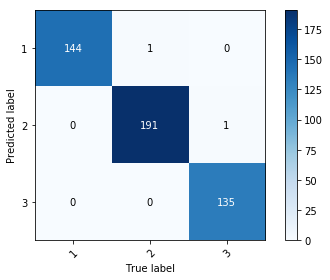

For Split: 2 , Accuracy Score:  0.9893617021276596
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       143
           2       0.99      0.98      0.99       192
           3       0.99      1.00      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


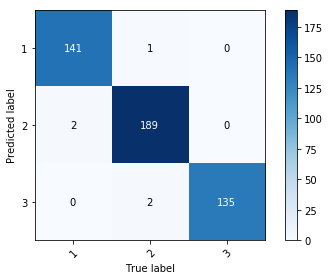

For Split: 3 , Accuracy Score:  0.9872340425531915
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       143
           2       0.99      0.98      0.98       192
           3       0.99      0.99      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


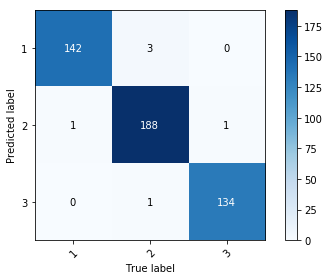

For Split: 4 , Accuracy Score:  0.9851063829787234
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       143
           2       0.97      0.99      0.98       192
           3       1.00      0.98      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.98      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


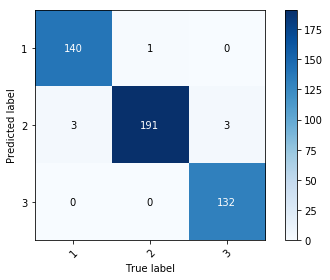

For Split: 5 , Accuracy Score:  0.9893617021276596
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       143
           2       0.97      1.00      0.99       192
           3       1.00      0.99      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


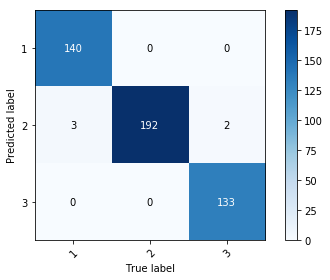

Mean Accuracy 0.9893653083303281
[0.9957627118644068, 0.9893617021276596, 0.9872340425531915, 0.9851063829787234, 0.9893617021276596, 0.9893653083303281, 'RGB,Logistic Regression']
     split1    split2    split3    split4    split5  avg_accuracy  \
0  0.995763  0.989362  0.987234  0.985106  0.989362      0.989365   

                   remarks  
0  RGB,Logistic Regression  
For LAB color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.9936440677966102
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       144
           2       0.98      1.00      0.99       192
           3       1.00      0.98      0.99       136

   micro avg       0.99      0.99      0.99       472
   macro avg       0.99      0.99      0.99       472
weighted avg       0.99      0.99      0.99       472

Confusion matrix, without normalization


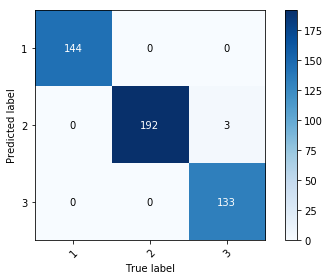

For Split: 2 , Accuracy Score:  0.9851063829787234
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       143
           2       0.99      0.97      0.98       192
           3       0.97      1.00      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.98      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


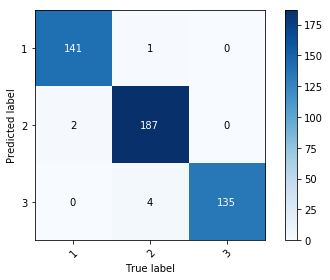

For Split: 3 , Accuracy Score:  0.9829787234042553
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       143
           2       0.98      0.98      0.98       192
           3       1.00      0.99      0.99       135

   micro avg       0.98      0.98      0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470

Confusion matrix, without normalization


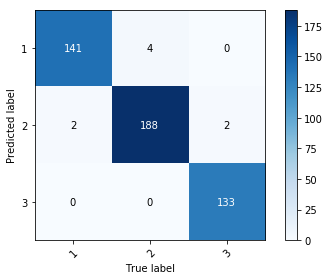

For Split: 4 , Accuracy Score:  0.9872340425531915
              precision    recall  f1-score   support

           1       0.99      0.98      0.98       143
           2       0.98      0.99      0.98       192
           3       1.00      0.99      1.00       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


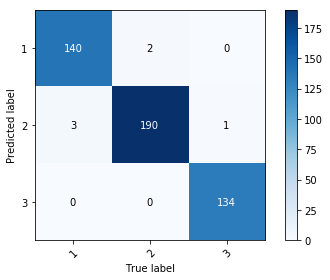

For Split: 5 , Accuracy Score:  0.9872340425531915
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       143
           2       0.98      0.99      0.98       192
           3       1.00      0.99      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


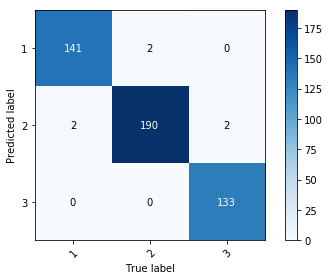

Mean Accuracy 0.9872394518571944
[0.9936440677966102, 0.9851063829787234, 0.9829787234042553, 0.9872340425531915, 0.9872340425531915, 0.9872394518571944, 'LAB,Logistic Regression']
     split1    split2    split3    split4    split5  avg_accuracy  \
0  0.993644  0.985106  0.982979  0.987234  0.987234      0.987239   

                   remarks  
0  LAB,Logistic Regression  
For HSV color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.961864406779661
              precision    recall  f1-score   support

           1       0.94      0.97      0.95       144
           2       0.96      0.95      0.95       192
           3       0.99      0.98      0.99       136

   micro avg       0.96      0.96      0.96       472
   macro avg       0.96      0.96      0.96       472
weighted avg       0.96      0.96      0.96       472

Confusion matrix, without normalization


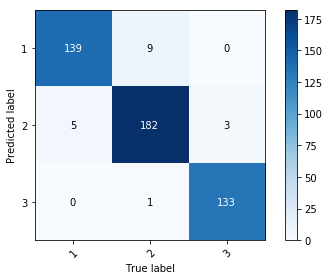

For Split: 2 , Accuracy Score:  0.951063829787234
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       143
           2       0.93      0.95      0.94       192
           3       0.98      0.96      0.97       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


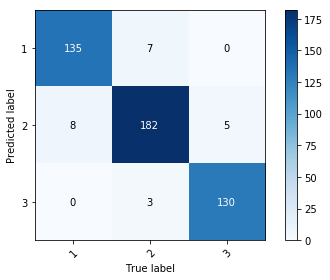

For Split: 3 , Accuracy Score:  0.9659574468085106
              precision    recall  f1-score   support

           1       0.99      0.94      0.97       143
           2       0.95      0.96      0.96       192
           3       0.96      0.99      0.97       135

   micro avg       0.97      0.97      0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470

Confusion matrix, without normalization


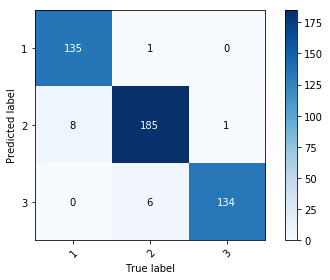

For Split: 4 , Accuracy Score:  0.9468085106382979
              precision    recall  f1-score   support

           1       0.93      0.93      0.93       143
           2       0.94      0.93      0.93       192
           3       0.97      0.99      0.98       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


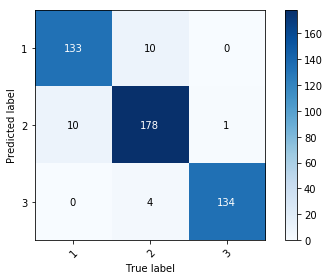

For Split: 5 , Accuracy Score:  0.9553191489361702
              precision    recall  f1-score   support

           1       0.92      0.97      0.94       143
           2       0.96      0.93      0.94       192
           3       0.99      0.98      0.99       135

   micro avg       0.96      0.96      0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470

Confusion matrix, without normalization


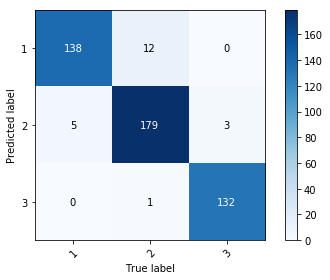

Mean Accuracy 0.9562026685899747
[0.961864406779661, 0.951063829787234, 0.9659574468085106, 0.9468085106382979, 0.9553191489361702, 0.9562026685899747, 'HSV,Logistic Regression']
     split1    split2    split3    split4    split5  avg_accuracy  \
0  0.961864  0.951064  0.965957  0.946809  0.955319      0.956203   

                   remarks  
0  HSV,Logistic Regression  


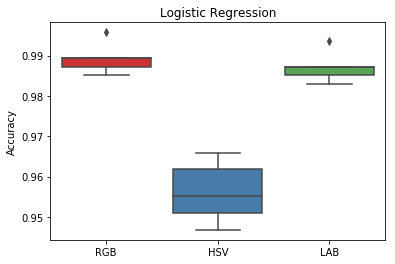

In [12]:
print ("For RGB color space")
L,V= load_RGB()
accuracy_score_list_RGB =Logistic_Regression(L, V,colorspace ="RGB")
print ("Mean Accuracy",np.mean(accuracy_score_list_RGB))
save_csv(accuracy_score_list_RGB,'cross_validation_downsampled_image.csv','RGB,Logistic Regression')

print ("For LAB color space")
L, V = load_LAB()
accuracy_score_list_LAB = Logistic_Regression(L, V,colorspace ="LAB")
print ("Mean Accuracy",np.mean(accuracy_score_list_LAB))
save_csv(accuracy_score_list_LAB,'cross_validation_downsampled_image.csv','LAB,Logistic Regression')

print ("For HSV color space")
L,V=load_HSV()
accuracy_score_list_HSV =Logistic_Regression(L,V,colorspace ="HSV")
print ("Mean Accuracy",np.mean(accuracy_score_list_HSV))
save_csv(accuracy_score_list_HSV,'cross_validation_downsampled_image.csv','HSV,Logistic Regression')

ax = sns.boxplot([accuracy_score_list_RGB,accuracy_score_list_HSV,accuracy_score_list_LAB],palette="Set1", whis= 2)
ax.set_xticks([0,1,2], ['RGB','HSV','LAB'])
ax.set(title= 'Logistic Regression' ,ylabel='Accuracy')
filename = "bar_plot_logistic_regression.png"
fig = ax.get_figure()
fig.savefig(filename)
plt.show()



### Train and Test SVM

For RGB color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.9936440677966102
              precision    recall  f1-score   support

           1       0.99      1.00      1.00       144
           2       0.99      0.99      0.99       192
           3       1.00      0.99      0.99       136

   micro avg       0.99      0.99      0.99       472
   macro avg       0.99      0.99      0.99       472
weighted avg       0.99      0.99      0.99       472

Confusion matrix, without normalization


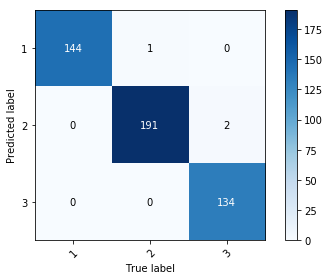

For Split: 2 , Accuracy Score:  0.9872340425531915
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       143
           2       0.98      0.98      0.98       192
           3       0.99      1.00      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


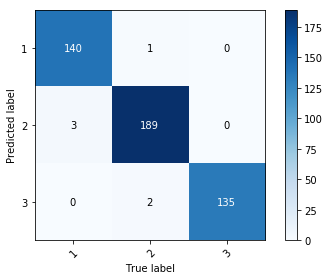

For Split: 3 , Accuracy Score:  0.9893617021276596
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       143
           2       0.99      0.98      0.99       192
           3       0.99      0.99      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


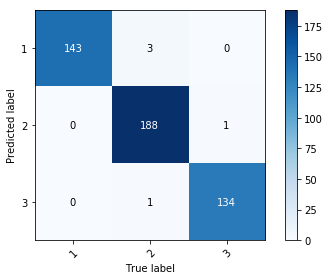

For Split: 4 , Accuracy Score:  0.9914893617021276
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       143
           2       0.98      0.99      0.99       192
           3       1.00      0.99      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


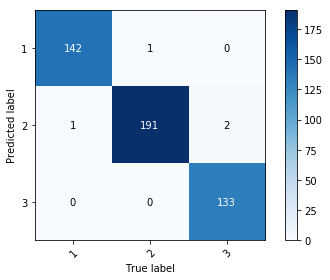

For Split: 5 , Accuracy Score:  0.9851063829787234
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       143
           2       0.98      0.98      0.98       192
           3       1.00      0.99      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


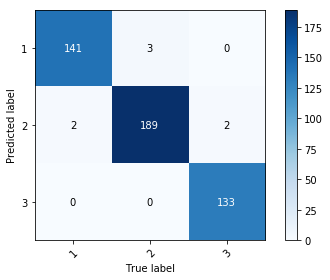

[0.9936440677966102, 0.9872340425531915, 0.9893617021276596, 0.9914893617021276, 0.9851063829787234, 0.9893671114316624, 'RGB,SVM']
     split1    split2    split3    split4    split5  avg_accuracy  remarks
0  0.993644  0.987234  0.989362  0.991489  0.985106      0.989367  RGB,SVM
Mean Accuracy 0.9893671114316624
SVM
For LAB color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.9978813559322034
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       144
           2       0.99      1.00      1.00       192
           3       1.00      0.99      1.00       136

   micro avg       1.00      1.00      1.00       472
   macro avg       1.00      1.00      1.00       472
weighted avg       1.00      1.00      1.00       472

Confusion matrix, without normalization


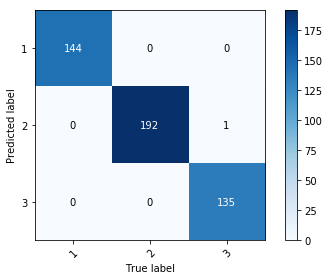

For Split: 2 , Accuracy Score:  0.9872340425531915
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       143
           2       0.98      0.98      0.98       192
           3       0.99      1.00      0.99       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


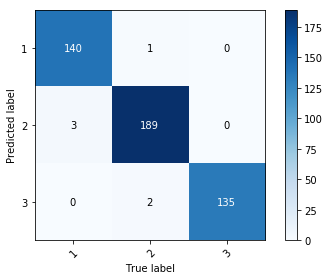

For Split: 3 , Accuracy Score:  0.9829787234042553
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       143
           2       0.98      0.97      0.98       192
           3       0.99      0.99      0.99       135

   micro avg       0.98      0.98      0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470

Confusion matrix, without normalization


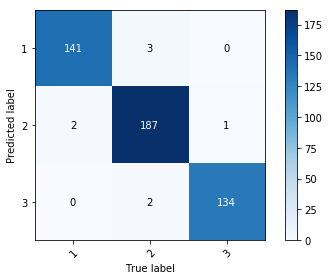

For Split: 4 , Accuracy Score:  0.9914893617021276
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       143
           2       0.98      0.99      0.99       192
           3       1.00      0.99      1.00       135

   micro avg       0.99      0.99      0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470

Confusion matrix, without normalization


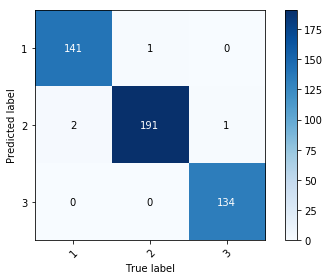

For Split: 5 , Accuracy Score:  0.9808510638297873
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       143
           2       0.97      0.98      0.98       192
           3       1.00      0.98      0.99       135

   micro avg       0.98      0.98      0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470

Confusion matrix, without normalization


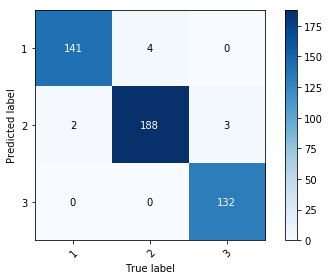

Mean Accuracy 0.988086909484313
[0.9978813559322034, 0.9872340425531915, 0.9829787234042553, 0.9914893617021276, 0.9808510638297873, 0.988086909484313, 'LAB,SVM']
     split1    split2    split3    split4    split5  avg_accuracy  remarks
0  0.997881  0.987234  0.982979  0.991489  0.980851      0.988087  LAB,SVM
For HSV color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.961864406779661
              precision    recall  f1-score   support

           1       0.94      0.97      0.95       144
           2       0.96      0.95      0.95       192
           3       0.99      0.98      0.99       136

   micro avg       0.96      0.96      0.96       472
   macro avg       0.96      0.96      0.96       472
weighted avg       0.96      0.96      0.96       472

Confusion matrix, without normalization


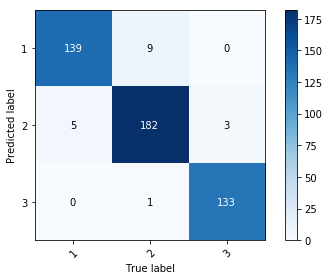

For Split: 2 , Accuracy Score:  0.9531914893617022
              precision    recall  f1-score   support

           1       0.95      0.94      0.94       143
           2       0.94      0.95      0.94       192
           3       0.98      0.98      0.98       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.96      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


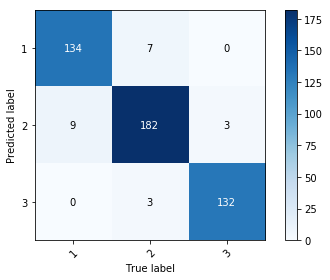

For Split: 3 , Accuracy Score:  0.9702127659574468
              precision    recall  f1-score   support

           1       0.99      0.94      0.97       143
           2       0.95      0.97      0.96       192
           3       0.97      0.99      0.98       135

   micro avg       0.97      0.97      0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470

Confusion matrix, without normalization


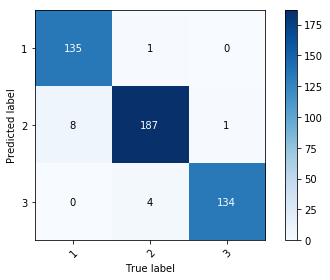

For Split: 4 , Accuracy Score:  0.9468085106382979
              precision    recall  f1-score   support

           1       0.92      0.92      0.92       143
           2       0.94      0.93      0.93       192
           3       0.99      1.00      0.99       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


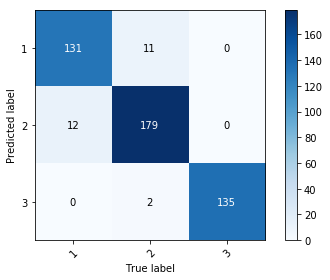

For Split: 5 , Accuracy Score:  0.9659574468085106
              precision    recall  f1-score   support

           1       0.94      0.98      0.96       143
           2       0.97      0.95      0.96       192
           3       0.99      0.98      0.99       135

   micro avg       0.97      0.97      0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470

Confusion matrix, without normalization


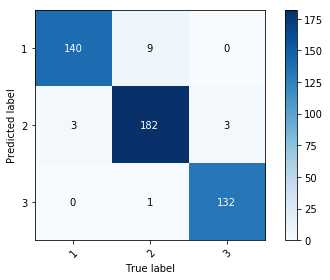

Mean Accuracy 0.9596069239091236
[0.961864406779661, 0.9531914893617022, 0.9702127659574468, 0.9468085106382979, 0.9659574468085106, 0.9596069239091236, 'HSV,SVM']
     split1    split2    split3    split4    split5  avg_accuracy  remarks
0  0.961864  0.953191  0.970213  0.946809  0.965957      0.959607  HSV,SVM


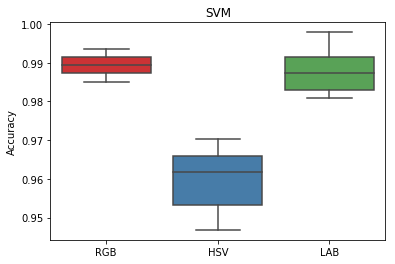

In [13]:
print ("For RGB color space")
L,V= load_RGB()
accuracy_score_list_RGB=SVM_Classifier(L, V,colorspace ="RGB")
save_csv(accuracy_score_list_RGB,'cross_validation_downsampled_image.csv','RGB,SVM')

print ("Mean Accuracy",np.mean(accuracy_score_list_RGB))

print ("SVM")
print ("For LAB color space")
L, V = load_LAB()
accuracy_score_list_LAB=SVM_Classifier(L, V,colorspace ="LAB")
print ("Mean Accuracy",np.mean(accuracy_score_list_LAB))
save_csv(accuracy_score_list_LAB,'cross_validation_downsampled_image.csv','LAB,SVM')

print ("For HSV color space")
L,V=load_HSV()
accuracy_score_list_HSV=SVM_Classifier(L,V,colorspace ="HSV")
print ("Mean Accuracy",np.mean(accuracy_score_list_HSV))
save_csv(accuracy_score_list_HSV,'cross_validation_downsampled_image.csv','HSV,SVM')

ax = sns.boxplot([accuracy_score_list_RGB,accuracy_score_list_HSV,accuracy_score_list_LAB],palette="Set1", whis= 2)
ax.set_xticks([0,1,2], ['RGB','HSV','LAB'])
ax.set(title= 'SVM' ,ylabel='Accuracy')
filename = "bar_plot_SVM.png"
fig = ax.get_figure()
fig.savefig(filename)
plt.show()


### Train and Test Random Forrest

For RGB color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.9639830508474576
              precision    recall  f1-score   support

           1       0.94      0.97      0.96       144
           2       0.97      0.94      0.95       192
           3       0.98      0.99      0.99       136

   micro avg       0.96      0.96      0.96       472
   macro avg       0.96      0.97      0.97       472
weighted avg       0.96      0.96      0.96       472

Confusion matrix, without normalization


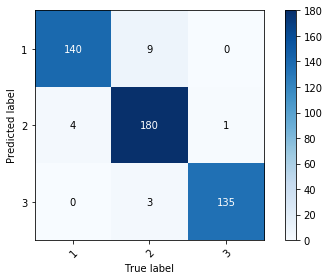

For Split: 2 , Accuracy Score:  0.9446808510638298
              precision    recall  f1-score   support

           1       0.92      0.98      0.95       143
           2       0.95      0.92      0.93       192
           3       0.97      0.95      0.96       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.94      0.94       470

Confusion matrix, without normalization


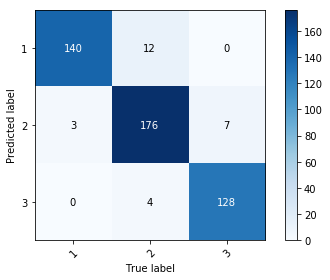

For Split: 3 , Accuracy Score:  0.9553191489361702
              precision    recall  f1-score   support

           1       0.94      0.96      0.95       143
           2       0.96      0.93      0.94       192
           3       0.96      0.99      0.97       135

   micro avg       0.96      0.96      0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470

Confusion matrix, without normalization


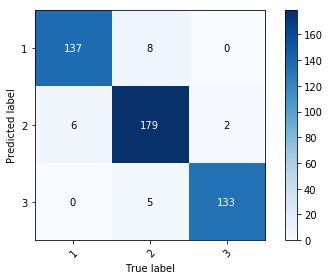

For Split: 4 , Accuracy Score:  0.9468085106382979
              precision    recall  f1-score   support

           1       0.90      0.97      0.93       143
           2       0.96      0.91      0.93       192
           3       0.98      0.99      0.98       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


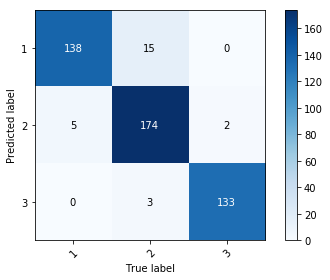

For Split: 5 , Accuracy Score:  0.9382978723404255
              precision    recall  f1-score   support

           1       0.90      0.99      0.94       143
           2       0.96      0.89      0.92       192
           3       0.96      0.96      0.96       135

   micro avg       0.94      0.94      0.94       470
   macro avg       0.94      0.94      0.94       470
weighted avg       0.94      0.94      0.94       470

Confusion matrix, without normalization


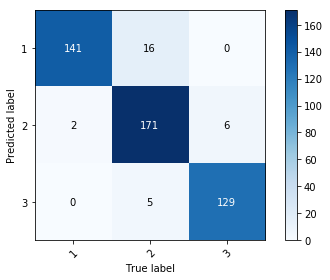

Mean Accuracy 0.9498178867652362
[0.9639830508474576, 0.9446808510638298, 0.9553191489361702, 0.9468085106382979, 0.9382978723404255, 0.9498178867652362, 'RGB,Random Forest']
     split1    split2    split3    split4    split5  avg_accuracy  \
0  0.963983  0.944681  0.955319  0.946809  0.938298      0.949818   

             remarks  
0  RGB,Random Forest  
Random Forrest
For LAB color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.9703389830508474
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       144
           2       0.96      0.96      0.96       192
           3       1.00      0.99      0.99       136

   micro avg       0.97      0.97      0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472

Confusion matrix, without normalization


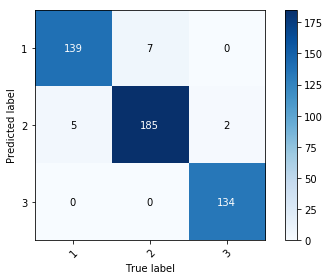

For Split: 2 , Accuracy Score:  0.9617021276595744
              precision    recall  f1-score   support

           1       0.96      0.95      0.96       143
           2       0.95      0.96      0.95       192
           3       0.98      0.98      0.98       135

   micro avg       0.96      0.96      0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470

Confusion matrix, without normalization


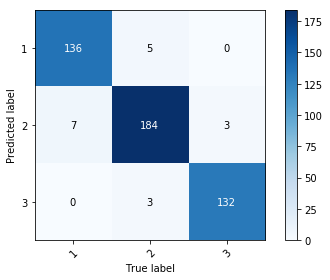

For Split: 3 , Accuracy Score:  0.9723404255319149
              precision    recall  f1-score   support

           1       0.97      0.94      0.96       143
           2       0.96      0.97      0.97       192
           3       0.99      1.00      1.00       135

   micro avg       0.97      0.97      0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470

Confusion matrix, without normalization


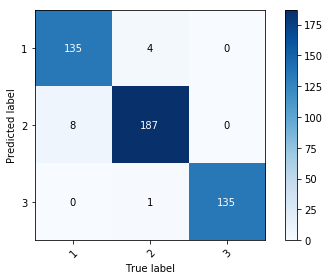

For Split: 4 , Accuracy Score:  0.948936170212766
              precision    recall  f1-score   support

           1       0.94      0.94      0.94       143
           2       0.93      0.94      0.94       192
           3       0.98      0.96      0.97       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


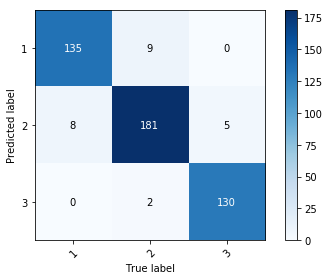

For Split: 5 , Accuracy Score:  0.9468085106382979
              precision    recall  f1-score   support

           1       0.94      1.00      0.97       143
           2       0.94      0.93      0.93       192
           3       0.96      0.92      0.94       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


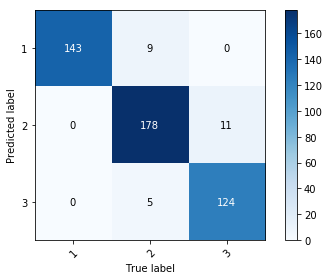

Mean Accuracy 0.9600252434186801
[0.9703389830508474, 0.9617021276595744, 0.9723404255319149, 0.948936170212766, 0.9468085106382979, 0.9600252434186801, 'LAB,Random Forest']
     split1    split2   split3    split4    split5  avg_accuracy  \
0  0.970339  0.961702  0.97234  0.948936  0.946809      0.960025   

             remarks  
0  LAB,Random Forest  
For HSV color space
(2352, 1536)
5
For Split: 1 , Accuracy Score:  0.972457627118644
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       144
           2       0.97      0.96      0.97       192
           3       1.00      0.99      1.00       136

   micro avg       0.97      0.97      0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472

Confusion matrix, without normalization


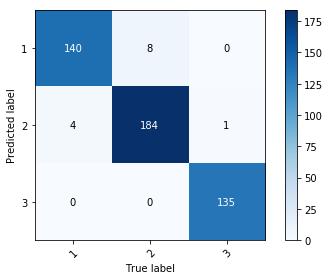

For Split: 2 , Accuracy Score:  0.9638297872340426
              precision    recall  f1-score   support

           1       0.95      0.96      0.95       143
           2       0.95      0.96      0.96       192
           3       0.99      0.98      0.99       135

   micro avg       0.96      0.96      0.96       470
   macro avg       0.97      0.96      0.97       470
weighted avg       0.96      0.96      0.96       470

Confusion matrix, without normalization


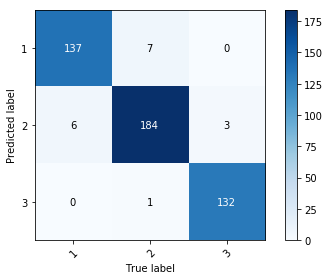

For Split: 3 , Accuracy Score:  0.9808510638297873
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       143
           2       0.99      0.96      0.98       192
           3       0.97      1.00      0.99       135

   micro avg       0.98      0.98      0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470

Confusion matrix, without normalization


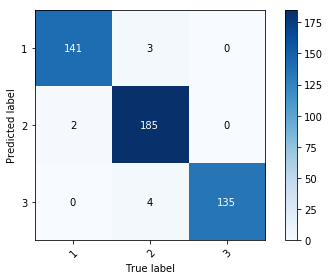

For Split: 4 , Accuracy Score:  0.9468085106382979
              precision    recall  f1-score   support

           1       0.93      0.95      0.94       143
           2       0.94      0.93      0.93       192
           3       0.98      0.97      0.97       135

   micro avg       0.95      0.95      0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Confusion matrix, without normalization


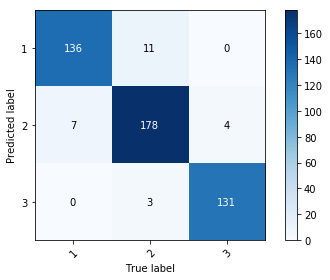

For Split: 5 , Accuracy Score:  0.9553191489361702
              precision    recall  f1-score   support

           1       0.93      0.99      0.96       143
           2       0.96      0.93      0.94       192
           3       0.98      0.96      0.97       135

   micro avg       0.96      0.96      0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470

Confusion matrix, without normalization


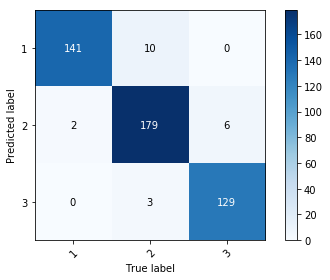

Mean Accuracy 0.9638532275513884
[0.972457627118644, 0.9638297872340426, 0.9808510638297873, 0.9468085106382979, 0.9553191489361702, 0.9638532275513884, 'HSV,Random Forest']
     split1   split2    split3    split4    split5  avg_accuracy  \
0  0.972458  0.96383  0.980851  0.946809  0.955319      0.963853   

             remarks  
0  HSV,Random Forest  


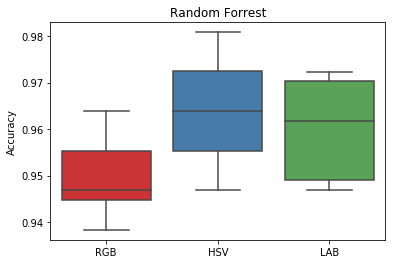

In [14]:
print ("For RGB color space")
L,V= load_RGB()
accuracy_score_list_RGB=Random_Forest(L, V,colorspace ="RGB")
print ("Mean Accuracy",np.mean(accuracy_score_list_RGB))
save_csv(accuracy_score_list_RGB,'cross_validation_downsampled_image.csv','RGB,Random Forest')

print ("Random Forrest")
print ("For LAB color space")
L, V = load_LAB()
accuracy_score_list_LAB=Random_Forest(L, V,colorspace ="LAB")
print ("Mean Accuracy",np.mean(accuracy_score_list_LAB))
save_csv(accuracy_score_list_LAB,'cross_validation_downsampled_image.csv','LAB,Random Forest')

print ("For HSV color space")
L,V=load_HSV()
accuracy_score_list_HSV=Random_Forest(L,V,colorspace ="HSV")
print ("Mean Accuracy",np.mean(accuracy_score_list_HSV))
save_csv(accuracy_score_list_HSV,'cross_validation_downsampled_image.csv','HSV,Random Forest')


ax = sns.boxplot([accuracy_score_list_RGB,accuracy_score_list_HSV,accuracy_score_list_LAB],palette="Set1", whis= 2)
ax.set_xticks([0,1,2], ['RGB','HSV','LAB'])
ax.set(title= 'Random Forrest' ,ylabel='Accuracy')
filename = "bar_plot_random_forest.png"
fig = ax.get_figure()
fig.savefig(filename)
plt.show()